In [1]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.metrics import roc_auc_score
from torch.nn.functional import relu
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = Path('/') / 'home' / 'user' / 'data'
TRAIN_DATA_PATH = DATA_PATH / 'ML' / 'train'
TEST_DATA_PATH = DATA_PATH / 'test'
TARGETS = ['target_0', 'target_1']

In [3]:
torch_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Define the dataset and data loader

In [4]:
class CamelyonDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, targets, transform=None):
        samples = list()
        labels = list()
        self.transform = transform
        for target in targets:
            data_paths = list((data_path / target).glob('*.jpg'))
            label = int(target.split('_')[-1])
            assert len(data_paths) > 0, f'Wrong data path: {data_path / target}'
            samples.extend(data_paths)
            labels.extend([label]*len(data_paths))
        self.samples = pd.DataFrame({'filepath': samples, 'label': labels})

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
    
        img_path = self.samples.iloc[idx, 0]
        data_path = str(img_path.resolve())
        image = read_image(data_path).to(torch_device)
        image = (1.0 / 255.0) * image
        
        label = self.samples.iloc[idx, 1]
        sample = image, label, data_path
        
        if self.transform:
            sample = self.transform(sample)
       
        return sample

In [5]:
dataset = CamelyonDataset(
    data_path=TRAIN_DATA_PATH,
    targets=TARGETS,
)
test_dataset = CamelyonDataset(
    data_path=TEST_DATA_PATH,
    targets=TARGETS,
)

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [7]:
# Evaluation code
def evaluate(model, loader):
    model.eval()

    all_labels = None
    all_preds = None
    all_data_paths = None
    
    with torch.no_grad():
        for batch in loader:
            inputs, labels, data_paths = batch
            # data_paths is a tuple
            data_paths = list(data_paths)
            labels = labels.to(torch_device).float().cpu().detach().numpy().tolist()
            
            # Apply a sigmoid on the predictions
            preds = torch.sigmoid(model(inputs))
            preds = preds.cpu().detach().numpy().tolist()

            if all_labels is None:
                all_labels = labels
                all_preds = preds
                all_data_paths = data_paths
            else:
                all_labels.extend(labels)
                all_preds.extend(preds)
                all_data_paths.extend(data_paths)

    return all_data_paths, all_preds, roc_auc_score(all_labels, all_preds)

## Define the model

In [8]:
class TorchModel(torch.nn.Module):
    
    def __init__(
        self,
    ):
        # This is a very simple model, performs badly
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = torch.nn.Linear(16 * 53 * 53, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 1)
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.pool(relu(x))
        x = self.pool(relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

## Train and evaluate the model

**DISCLAIMER**: I should create a separate validation and test set from the train data and do nothing on the test set until the submission. Otherwise I will overfit the test set.

In [9]:
n_epochs = 2

model = TorchModel().to(torch_device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_perfs = list()
train_perfs = list()

all_labels = None
all_preds = None
all_data_paths = None
    
for epoch in range(n_epochs):
    model.train()
    for batch in dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, data_paths = batch
        labels = labels.to(torch_device).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    _, _, train_score = evaluate(model, loader=dataloader)
    train_perfs.append(train_score)

    data_paths, predictions, test_score = evaluate(model, loader=test_dataloader)
    test_perfs.append(test_score)
    print(f'Epoch {epoch+1}/{n_epochs} - Train AUC: {train_score} - Test AUC: {test_score}')

Epoch 1/2 - Train AUC: 0.8683570009735853 - Test AUC: 0.7781404428440862
Epoch 2/2 - Train AUC: 0.9275283015698161 - Test AUC: 0.7636532516953739


## Display the results

In [10]:
%matplotlib inline

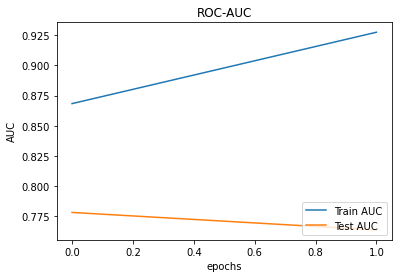

In [11]:
# Plot the results
plt.title('ROC-AUC')
plt.plot(list(range(n_epochs)), train_perfs,label = 'Train AUC')
plt.plot(list(range(n_epochs)), test_perfs, label = 'Test AUC')
plt.legend(loc = 'lower right')
plt.ylabel('AUC')
plt.xlabel('epochs')
plt.show()

## Kaggle submission

In [12]:
df_submission = pd.DataFrame(data={'file_paths': data_paths, 'predictions': predictions})
df_submission["file_paths"] = df_submission["file_paths"].apply(lambda x: x.replace("/home/user/data/test","/data/challenges_data/test"))
df_submission.to_csv('df_submission.csv', index=False)

In [13]:
df_submission.head()

,file_paths,predictions
0,/data/challenges_data/test/target_0/normal_1_1...,0.620471
1,/data/challenges_data/test/target_0/normal_0_4...,0.706707
2,/data/challenges_data/test/target_0/normal_1_1...,0.751138
3,/data/challenges_data/test/target_0/normal_0_4...,0.101923
4,/data/challenges_data/test/target_0/normal_0_1...,0.129125
